In [ ]:
from sigvisa.treegp.gp import GPCov, GP
from sigvisa.ssms_c import CompactSupportSSM, TransientCombinedSSM
from sigvisa.models.joint_gp import JointGP
from sigvisa.models.wiggles.wavelets import construct_padded_implicit_basis
import scipy.stats
import pyublas 
gpcov = GPCov([0.7,], [ 40.0, 5.0],
                  dfn_str="lld",
                  wfn_str="compact2")
wiggle_prior = (0.01, gpcov)
jgp = JointGP("bump", "CM16", 0.0, 0.1, gpcov)

basis, iid_scale, cvar = construct_padded_implicit_basis(5.0, wavelet_str="dbug_single")#"db4_2.0_3_30")#

starray, etarray, idarray, m, N = basis
pm, pv = jgp.prior()

cssm = CompactSupportSSM(starray, etarray, idarray, m, np.array([pm,]*len(starray), dtype=float), np.array([pv,]*len(starray), dtype=float), 0.01, 0.0)
tssm = TransientCombinedSSM([(cssm, 0, 300, None)], 0.01)




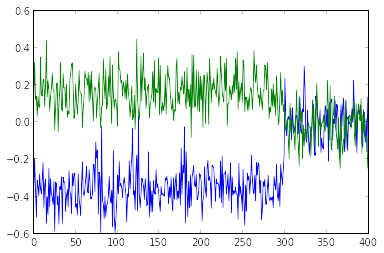

In [14]:
loc1 = {"lon": 1.0, "lat": 1.0, "depth": 0.0, "mb": 5.0, "time": 1500.0}
loc2 = {"lon": 1.1, "lat": 1.1, "depth": 0.0, "mb": 5.0, "time": 1500.0}

x1 = jgp._ev_features(loc1).reshape((1, -1))
x2 = jgp._ev_features(loc2).reshape((1, -1))

np.random.seed(0)
z1 = tssm.prior_sample(400)
z2 = tssm.prior_sample(400)

plot(z1)
plot(z2)

In [18]:
n_coefs = len(starray)
adj = 1e10
cssm.set_coef_prior(np.zeros((n_coefs)), np.ones((n_coefs))*adj)
message_ll1 = cssm.run_filter(z1) 
norm = scipy.stats.norm.logpdf(0, scale=np.sqrt(adj))
message_ll2 = message_ll1 - norm
message_means, message_vars = tssm.all_filtered_cssm_coef_marginals(z1)[0]
#print message_means, message_vars
print message_ll1, norm
print message_ll2


335.025270608 -12.4318639982
347.457134606


In [21]:
prior_means, prior_vars = np.zeros((n_coefs)), np.ones((n_coefs))*0.001
cssm.set_coef_prior(prior_means, prior_vars)
Z = cssm.run_filter(z1)
posterior_means, posterior_vars = tssm.all_filtered_cssm_coef_marginals(z1)[0]
#print posterior_means, posterior_vars
correction = np.sum([ np.log(prior_vars[i]-posterior_vars[i]) - np.log(prior_vars[i]) +\
                     scipy.stats.norm(loc=posterior_means[i], \
                                       scale=np.sqrt(prior_vars[i]-posterior_vars[i])).logpdf(prior_means[i]) \
                     for i in range(n_coefs) ])
print Z, correction, Z-correction

289.565387373 -57.8917472337 347.457134606


In [6]:
cssm.set_coef_prior(message_means, np.zeros(message_means.shape))
ll_at_mean = cssm.run_filter(z1)
print ll_at_mean

normalized_at_mean = np.sum([scipy.stats.norm(scale=np.sqrt(v)).logpdf(0) for v in message_vars])
#nam = np.sum([-.5*np.log(2*np.pi*v) for v in message_vars])
print ll_at_mean - normalized_at_mean


363.928032248
359.692494451


357.474919742


In [20]:
"""
global LP:
   - logp of both signals under the prior probability
   - 
   
   
"""

posterior_means, posterior_vars = tssm.all_filtered_cssm_coef_marginals(z1)[0]
posterior_means2, posterior_vars2 = tssm.all_filtered_cssm_coef_marginals(z2)[0]

prior_means, prior_vars = cssm.get_coef_prior()
print prior_means, prior_vars

jgp.message_from_arrival(1, loc1, prior_means[0], prior_vars[0], posterior_means[0], posterior_vars[0])
jgp.message_from_arrival(2, loc2, prior_means[0], prior_vars[0], posterior_means[0], posterior_vars[0])

signal1_lp = cssm.run_filter(z1)
signal2_lp = cssm.run_filter(z2)
jgp_ll1 = jgp.log_likelihood()
jgp.message_from_arrival(2, loc2, prior_means[0], prior_vars[0], posterior_means2[0], posterior_vars2[0])
jgp_ll2 = jgp.log_likelihood()

global_lp1 = signal1_lp + signal1_lp + jgp_ll1
global_lp2 = signal1_lp + signal2_lp + jgp_ll2

print signal1_lp, signal2_lp, signal2_lp-signal1_lp
print jgp_ll1, jgp_ll2, jgp_ll2-jgp_ll1

print global_lp1
print global_lp2
print global_lp2-global_lp1




[ 0.] [ 0.8]
351.610420245 317.027208855 -34.5832113896
-1.65930591729 -2.08607123806 -0.426765320772
701.561534572
666.551557862
-35.0099767104


In [32]:
print np.diag(K) - jgp._cached_gp[None].y_obs_variances

[ 0.8  0.8]


In [33]:


M = np.zeros((800,2))
M[:300, 0] = 1.0
M[400:700, 1] = 1.0
K = jgp._cached_gp[None].K.copy()
np.fill_diagonal(K, np.diag(K) - jgp._cached_gp[None].y_obs_variances)
scov = np.eye(800)*0.01 + np.dot(M, np.dot(K, M.T))

c11 = scov[:400, :400]
c12 = scov[:400, 400:800]
c11_inv = np.linalg.inv(c11)
conditional_cov = c11 - np.dot(c12.T, np.dot(c11_inv, c12))
def conditional_signal_mean(s1):
    return np.dot(c12.T, np.dot(c11_inv, s1))

M1 = M[:400,:]
Kinv = np.linalg.inv(K)
noise_cov = np.eye(400)*0.01
nc_inv = np.linalg.inv(noise_cov)
C = np.linalg.inv((Kinv + np.dot(M1.T, np.dot(nc_inv, M1))))
def conditional_coef_mean(s1):
    return np.dot(C, np.dot(M1.T, np.dot(nc_inv, s1)))


In [3]:
import scipy.stats

marginal_dist = scipy.stats.multivariate_normal(mean=np.zeros((400,)), cov=scov[:400,:400])
marginal_lp1 = marginal_dist.logpdf(z1)
marginal_lp2 = marginal_dist.logpdf(z2)
print "marginal", marginal_lp1, marginal_lp2

overall_dist = scipy.stats.multivariate_normal(mean=np.zeros((800,)), cov=scov)
overall_lp = overall_dist.logpdf(np.concatenate((z1, z1)))
print "overall", overall_lp

conditional_dist = scipy.stats.multivariate_normal(mean=conditional_signal_mean(z1), cov=conditional_cov)
conditional_lp = conditional_dist.logpdf(z1)
print "conditional", conditional_lp

print "marginal+conditional", marginal_lp1+conditional_lp

print "coef posterior"
print C
print conditional_coef_mean(z1)

NameError: name 'scov' is not defined

In [40]:
print message_ll*2 + jgp_ll1

703.244305817


In [35]:
print posterior_means, posterior_vars
print jgp.posterior(2)

[ 0.23322647] [  3.33319445e-05]
(0.038519785371700435, array([ 0.77817853]))


In [29]:
# let's compute posterior on c1 given s1. 

# this is the CSSM posterior: should be correct?
print posterior_means, posterior_vars

# the exact Gaussian posterior
MM = np.zeros((400,))
MM[:300]=1.0
true_posterior_var = 1.0/(1.0/pv + np.dot(MM, np.dot(nc_inv, MM)))
true_posterior_mean = true_posterior_var * np.dot(MM, np.dot(nc_inv, z1))
print true_posterior_mean, true_posterior_var

# the GP posterior
x1 = x1.reshape((1, -1))
gp_mean = jgp._cached_gp[2].predict(x1)
gp_var = jgp._cached_gp[2].variance(x1, pad=0)
print gp_mean, gp_var

# p(c1|s1) = p(s1|c1)p(c1)
# where given c1, s1 is sampled with a coef equal to c1 plus some obs noise. 
# this is really p(s1|k)p(k|c1)p(c1)
# where we integrate over k to get 
s_cond_cov = noise_cov + np.outer(MM, MM)*0.1
CC = 1.0/(1.0/0.7 + np.dot(MM, np.dot(np.linalg.inv(s_cond_cov), MM)))
print CC



[ 0.23322647] [  3.33319445e-05]
0.233226467554 3.33319445023e-05
0.20407315911 [ 0.08752552]
0.08752551977


In [30]:
print jgp._cached_gp[2].variance(x1, pad=0)[0]

0.08752551977


In [15]:
print jgp._cached_gp[None].variance(np.array([1.0, 1.0, 0.0, 5.0, 1000.0]).reshape((1, -1)), include_obs=True)

[ 0.1871748]


In [36]:
gpm, gpv = jgp.posterior(2)
print gpm, gpv
cssm.set_coef_prior(np.array((gpm,), dtype=float), np.array((gpv,), dtype=float))
conditional_lp1 = cssm.run_filter(z1)
conditional_lp2 = cssm.run_filter(z2)
cssm.set_coef_prior(np.array((pm,), dtype=float), np.array((pv,), dtype=float))
print conditional_lp1
print conditional_lp2
print conditional_lp2-conditional_lp1

0.0385197853717 [ 0.77817853]
351.633885573
317.070003578
-34.563881995


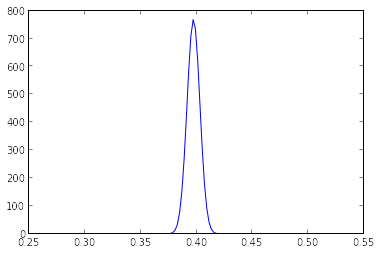

In [30]:
print log_normalizer



352.409255156


In [6]:
global_lp1 = sg.current_log_p(verbose=False)
unconditional_lp1 = wn2.log_p()
wn2.conditional_coef_distribution=True
conditional_lp1 = wn2.log_p()

tmnodes = sg.get_template_nodes(2, wn.sta, "P", wn.band, wn.chan)
k, n = tmnodes["coda_height"]
n.set_value(1.1)
wn2._parent_values()
wn2.pass_jointgp_messages()

conditional_lp2 = wn2.log_p()
wn2.conditional_coef_distribution=False
unconditional_lp2 = wn2.log_p()
global_lp2 = sg.current_log_p(verbose=False)

k, n = tmnodes["coda_height"]
n.set_value(1.0)
wn2._parent_values()
wn2.pass_jointgp_messages()

print "global", global_lp2-global_lp1
print "conditional", conditional_lp2-conditional_lp1
print "unconditional", unconditional_lp2-unconditional_lp1

passing messages from <sigvisa.ssms_c.CompactSupportSSM object at 0x4876788> vs <sigvisa.ssms_c.CompactSupportSSM object at 0x4876788>
passing messages from <sigvisa.ssms_c.CompactSupportSSM object at 0x4876788> vs <sigvisa.ssms_c.CompactSupportSSM object at 0x4876788>
global -13.5332741441
conditional -13.4526010598
unconditional -13.4652225102


In [21]:
print global_lp1, global_lp2
print conditional_lp1, conditional_lp2
print unconditional_lp1, unconditional_lp2

5429.61963234 5424.67637438
2512.18965395 2490.0016546
2468.67955344 2442.49884147


In [3]:
from sigvisa.treegp.gp import GP

X1 = np.array((4.0, 4.0, 0.0, 0.0, 5.0)).reshape(1, -1)
X2 = np.array((4.1, 4.1, 0.0, 0.0, 5.0)).reshape(1, -1)
X = np.vstack([X1, X2])

y1 = np.array((3.2,))
y2 = np.array((3.1,))
y = np.concatenate((y1, y2))
print y

yv1 = np.array((0.4,))
yv2 = np.array((0.2,))
yv = np.concatenate((yv1, yv2))
print yv

gp = GP(X=X, y=y, y_obs_variances=yv, noise_var=0.1, cov_main=gpcov, compute_ll=True, sparse_invert=True)
print gp.log_likelihood()

print gp.predict_tree.sparse_training_kernel_matrix(gp.X, 1.0, False)

gp1 = GP(X=X1, y=y1, y_obs_variances=yv1 , noise_var=0.1, cov_main=gpcov, compute_ll=True, sparse_invert=True)
print gp1.log_likelihood()
print gp1.predict(X2)
print gp1.variance(X2)

import scipy.stats
lp2 = scipy.stats.norm.logpdf(y2[0], loc=gp1.predict(X2), scale=np.sqrt(gp1.variance(X2) + 0.1 + yv2))
print gp1.log_likelihood() + lp2

[ 3.2  3.1]
[ 0.4  0.2]
-10.0155198303
[[ 0.          0.          0.7       ]
 [ 0.          1.          0.13263612]
 [ 1.          0.          0.13263612]
 [ 1.          1.          0.7       ]]
-5.27676594688
0.353696319335
[ 0.68533973]
[-10.01551983]


In [1]:
print conditional_lp2-conditional_lp1

NameError: name 'conditional_lp2' is not defined